## DL Model on Tabular Data

- "in most cases the DL models performed worse on unseen datasets"
- "XGBoost/LightGBM models generally outperformed the deep models"
- "no DL model consistently outperformed the others"
- "ensemble of deep models and XGBoost outperforms the other models in most cases"

And here goes...

## TabNet
- Paper: https://arxiv.org/abs/1908.07442
- Torch Framework: https://github.com/dreamquark-ai/tabnet
- Google Cloud: https://cloud.google.com/ai-platform/training/docs/algorithms/tab-net-start

### TabNet Architecture

<img src="images/tabnet_arch.png" width="1000">

#### Entmax for different alphas (Sparsemax: alpha=2)

<img src="images/entmax.png" width="400">

### TabNet Advantages

- MultiTaskClassifier, MultiRegressor
- interpretability using Masks
- use all the deep-learning concepts like LR scheduler, Custom loss, etc
- no feature selection
- it achieves high scores without feature engineering and finetuning
- self-supervised learning (pre-training)

#### Installing

In [1]:
#!pip install pytorch-tabnet

#### Import packages

In [2]:
import os
import random

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputClassifier
import torch
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from xgboost import XGBClassifier

from utils import (
    deterministic, encode_categorical, fit_and_predict, fit_and_predict_xgb, 
    extract_fold, feature_importances, feature_importances_xgb, get_diff_distribution_features
)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#configs
NUM_FOLDS = 5
seed = 2021

In [5]:
deterministic(seed)

In [6]:
!kaggle competitions files -c lish-moa

name                          size  creationDate         
---------------------------  -----  -------------------  
test_features.csv             25MB  2020-11-03 20:33:37  
train_targets_scored.csv      10MB  2020-11-03 20:33:37  
sample_submission.csv          3MB  2020-11-03 20:33:37  
train_features.csv           149MB  2020-11-03 20:33:37  
train_targets_nonscored.csv   19MB  2020-11-03 20:33:37  
train_drug.csv               535KB  2020-11-03 20:33:37  


In [7]:
!kaggle competitions download -c lish-moa -p data/ && cd data/ && unzip lish-moa.zip

100%|██████████████████████████████████████| 64.7M/64.7M [00:49<00:00, 1.44MB/s]
100%|██████████████████████████████████████| 64.7M/64.7M [00:49<00:00, 1.38MB/s]
Archive:  lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_drug.csv          
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  


#### Load data

In [8]:
X = pd.read_csv("data/train_features.csv")
y = pd.read_csv('data/train_targets_scored.csv')
print(f"X shape: {X.shape} \ny shape: {y.shape}")

X shape: (23814, 876) 
y shape: (23814, 207)


In [9]:
X.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


In [10]:
y.head(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# is ID order the same
f"Same ID in X and y: {(X['sig_id'] == y['sig_id']).sum()}"

'Same ID in X and y: 23814'

In [12]:
# drop id column
X.drop(columns=["sig_id"], inplace=True)
y.drop(columns=["sig_id"], inplace=True)

### Categorical variables

In [13]:
print("Categorical features:")
train_unique_ds = X.nunique()
train_unique_ds[train_unique_ds < 200]

Categorical features:


cp_type    2
cp_time    3
cp_dose    2
dtype: int64

In [14]:
print("Categorical targets:")
train_unique_ds = y.nunique()
train_unique_ds[train_unique_ds < 200]

Categorical targets:


5-alpha_reductase_inhibitor              2
11-beta-hsd1_inhibitor                   2
acat_inhibitor                           2
acetylcholine_receptor_agonist           2
acetylcholine_receptor_antagonist        2
                                        ..
ubiquitin_specific_protease_inhibitor    2
vegfr_inhibitor                          2
vitamin_b                                2
vitamin_d_receptor_agonist               2
wnt_inhibitor                            2
Length: 206, dtype: int64

In [15]:
X, cat_ids, cat_dimensions, encoders = encode_categorical(X)

Unique values for cp_type: 2
Unique values for cp_time: 3
Unique values for cp_dose: 2


In [16]:
X.head(3)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


### Missing values

In [17]:
is_na = lambda x: f"Number of NAs in dataset: {x.isna().sum().sum()}"
is_na(X)

'Number of NAs in dataset: 0'

In [18]:
# make some NAs
for col in random.sample(list(range(X.shape[1])), 8):
    for row in random.sample(list(range(X.shape[0])), random.randint(0, int(0.1 * X.shape[0]))):
        X.iat[row, col] = np.nan
is_na(X)

'Number of NAs in dataset: 9892'

In [19]:
columns_with_nas = X.columns[X.isnull().any()].to_list()
f"Columns with NAs: {columns_with_nas}"

"Columns with NAs: ['g-32', 'g-250', 'g-280', 'g-410', 'g-554', 'g-641', 'g-647', 'c-81']"

<AxesSubplot:>

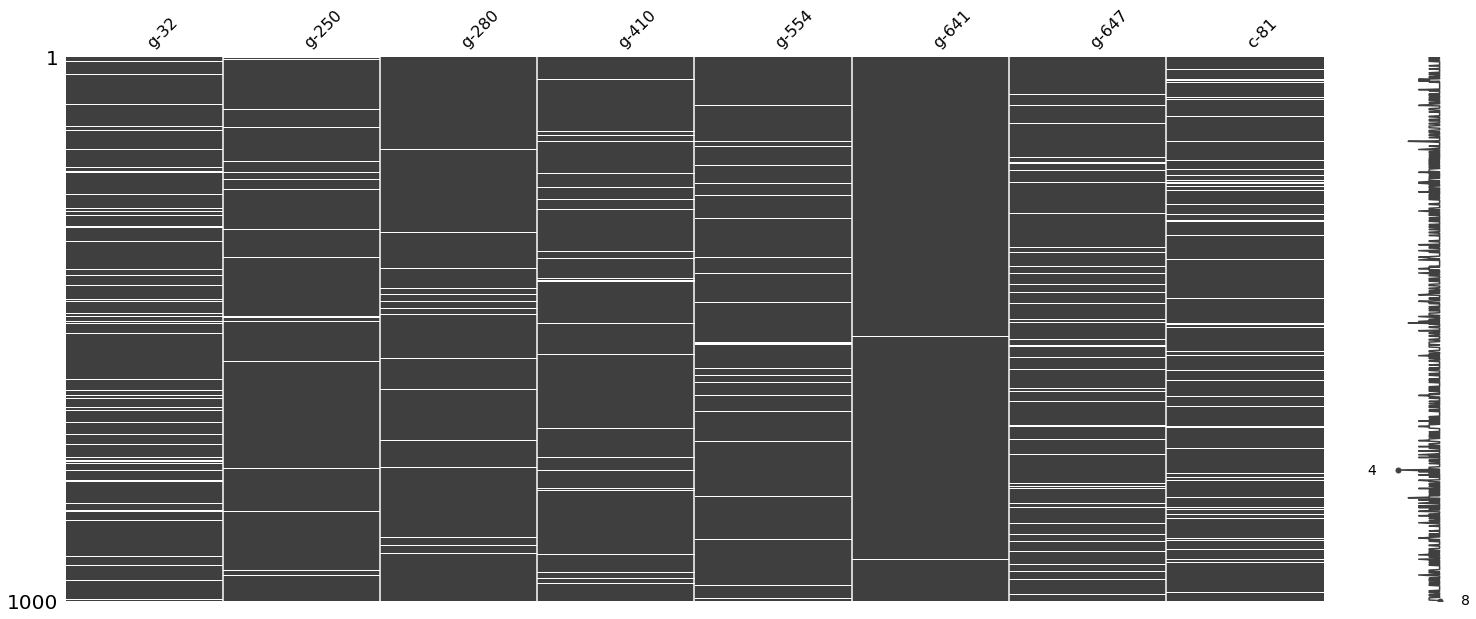

In [20]:
# draw NAs
import missingno as msno
msno.matrix(X[columns_with_nas].sample(1000))

In [21]:
# impute missing values
X.fillna(X.mean(), inplace=True)
is_na(X)

'Number of NAs in dataset: 0'

#### Make K folds

In [22]:
kf = KFold(n_splits=5, shuffle=True)
folds = {fn: (train_idx, val_idx) for fn, (train_idx, val_idx) in enumerate(kf.split(X, y))}

In [23]:
# simplification trick - keep only tasks with more than one label in train and valid
targets = set(y.columns)
for fn in folds:
    y_train_check = y.iloc[folds[fn][0]]
    one_cat_train_columns = y_train_check.columns[y_train_check.nunique() < 2]
    y_valid_check = y.iloc[folds[fn][1]]
    one_cat_valid_columns = y_valid_check.columns[y_valid_check.nunique() < 2]
    targets = targets - set(one_cat_train_columns) - set(one_cat_valid_columns)
targets = list(targets)
print(f"Number of targets to predict (after targets with one value is removed): {len(targets)}")
y_to_predict = y[targets]

Number of targets to predict (after targets with one value is removed): 177


### Define Network

In [24]:
def init_tabnet():
    print("New TabNetMultiTaskClassifier initialized.")
    return TabNetMultiTaskClassifier(
        cat_idxs=cat_ids,
        cat_dims=cat_dimensions,
        cat_emb_dim=2,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params={"step_size":50, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        mask_type="entmax",
        lambda_sparse=0,
    )

New TabNetMultiTaskClassifier initialized.
Device used : cuda
Training for fold 0:
epoch 0  | loss: 0.542   | train_auc: 0.5029  | train_logloss: 0.11152 | valid_auc: 0.48501 | valid_logloss: 0.11227 |  0:00:03s
epoch 40 | loss: 0.02035 | train_auc: 0.68521 | train_logloss: 0.02018 | valid_auc: 0.66247 | valid_logloss: 0.02011 |  0:02:36s
epoch 80 | loss: 0.01913 | train_auc: 0.74811 | train_logloss: 0.01891 | valid_auc: 0.69773 | valid_logloss: 0.01908 |  0:05:10s
epoch 120| loss: 0.0184  | train_auc: 0.78263 | train_logloss: 0.01811 | valid_auc: 0.71675 | valid_logloss: 0.01857 |  0:07:40s
epoch 160| loss: 0.01764 | train_auc: 0.81751 | train_logloss: 0.01735 | valid_auc: 0.72617 | valid_logloss: 0.01844 |  0:10:14s

Early stopping occurred at epoch 199 with best_epoch = 149 and best_valid_logloss = 0.0184
Best weights from best epoch are automatically used!


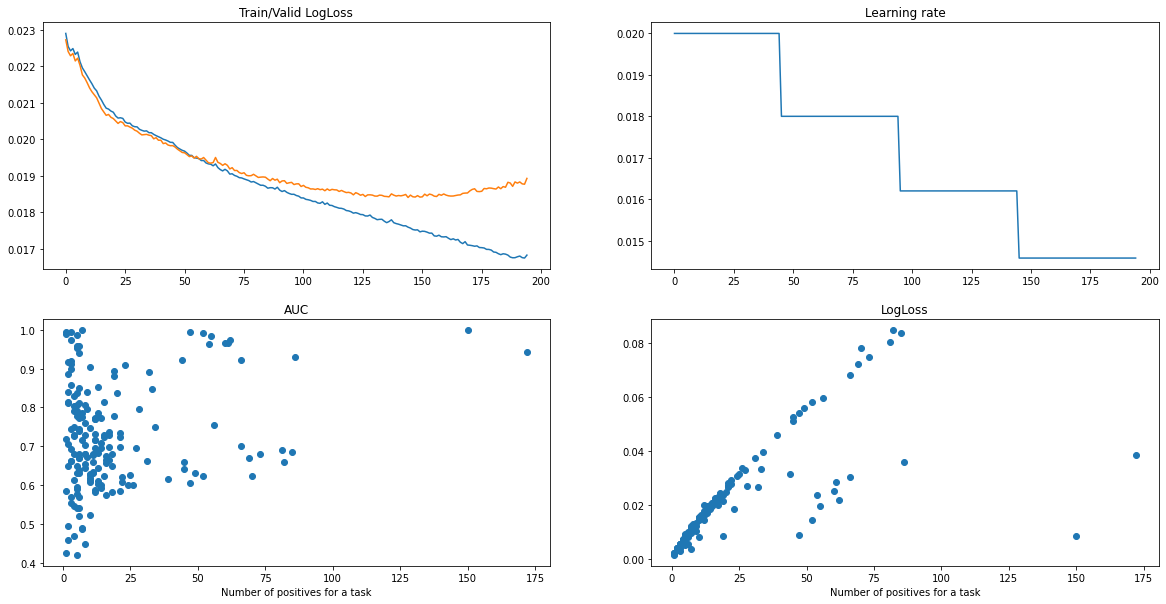

In [25]:
clf_0, valid_aucs_0 = fit_and_predict(init_tabnet(), X, y_to_predict, folds, fold_ix=0, max_epochs=201, verbose=40)

New TabNetMultiTaskClassifier initialized.
Device used : cuda
Training for fold 1:
epoch 0  | loss: 0.55225 | train_auc: 0.50971 | train_logloss: 0.12263 | valid_auc: 0.51129 | valid_logloss: 0.12207 |  0:00:03s
epoch 40 | loss: 0.02074 | train_auc: 0.67912 | train_logloss: 0.02049 | valid_auc: 0.65774 | valid_logloss: 0.02104 |  0:02:37s
epoch 80 | loss: 0.0193  | train_auc: 0.76081 | train_logloss: 0.01899 | valid_auc: 0.71428 | valid_logloss: 0.01977 |  0:05:12s
epoch 120| loss: 0.01789 | train_auc: 0.80153 | train_logloss: 0.01757 | valid_auc: 0.72921 | valid_logloss: 0.01907 |  0:07:48s
epoch 160| loss: 0.01712 | train_auc: 0.83004 | train_logloss: 0.01679 | valid_auc: 0.73918 | valid_logloss: 0.01901 |  0:10:24s

Early stopping occurred at epoch 194 with best_epoch = 144 and best_valid_logloss = 0.01891
Best weights from best epoch are automatically used!


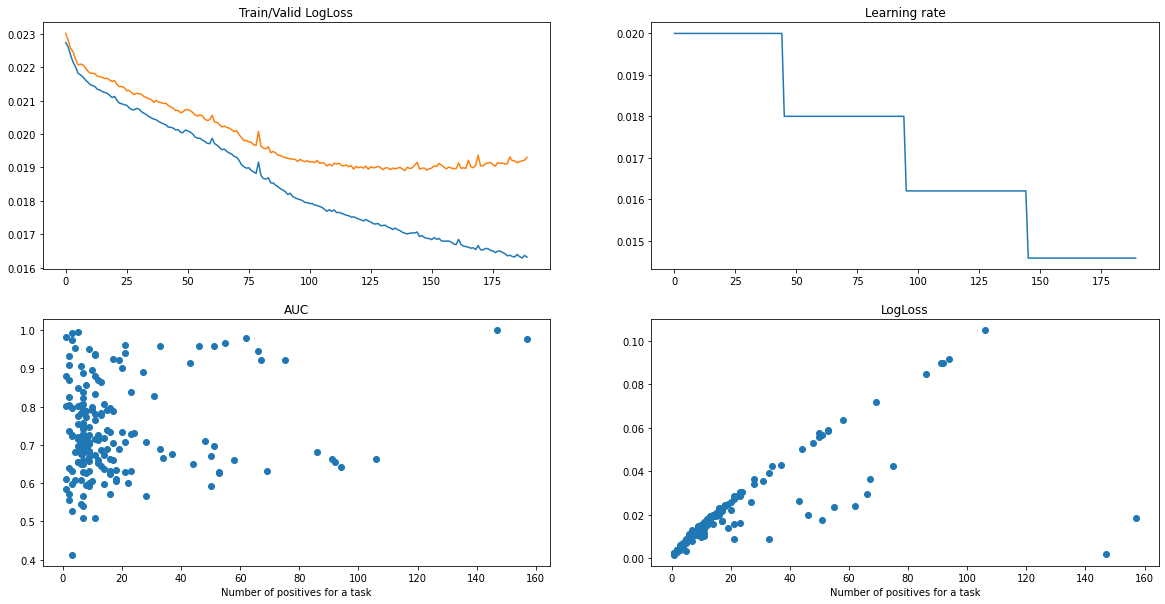

In [26]:
clf_1, valid_aucs_1 = fit_and_predict(init_tabnet(), X, y_to_predict, folds, fold_ix=1, max_epochs=201, verbose=40)

#### Feature importances

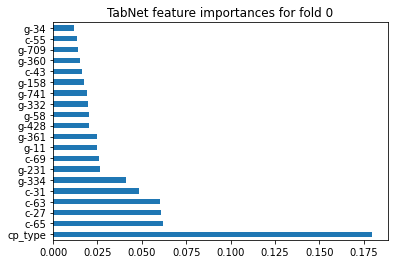

In [27]:
feature_importances(clf_0, X, 0)

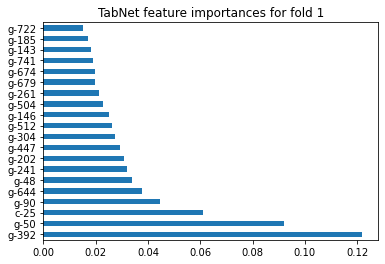

In [28]:
feature_importances(clf_1, X, 1)

In [29]:
_, _, X_fold_3, _ = extract_fold(X, y_to_predict, folds, fold_ix=3)
explain_matrix, masks = clf_0.explain(X_fold_3)

In [30]:
print("TabNet Explain Matrix for fold 3:")
pd.DataFrame(explain_matrix).describe()

TabNet Explain Matrix for fold 3:


,0,1,2,3,4,5,6,7,8,9,...,865,866,867,868,869,870,871,872,873,874
count,4763.000000,4763.000000,4763.000000,4763.0,4763.0,4763.000000,4763.0,4.763000e+03,4763.000000,4763.000000,...,4763.0,4763.000000,4.763000e+03,4763.000000,4763.0,4763.0,4763.0,4763.0,4763.0,4763.0
mean,1.622300,0.000001,0.000004,0.0,0.0,0.000078,0.0,2.882887e-07,0.000011,0.000006,...,0.0,0.020278,8.879488e-10,0.000103,0.0,0.0,0.0,0.0,0.0,0.0
std,4.003972,0.000063,0.000192,0.0,0.0,0.004393,0.0,1.989610e-05,0.000288,0.000241,...,0.0,0.164763,5.783930e-08,0.001733,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,...,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.358058,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,...,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.476332,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,...,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.592175,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,...,0.0,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,18.291238,0.004210,0.013069,0.0,0.0,0.295266,0.0,1.373119e-03,0.015323,0.014694,...,0.0,4.756405,3.984274e-06,0.067063,0.0,0.0,0.0,0.0,0.0,0.0


TabNet Masks:


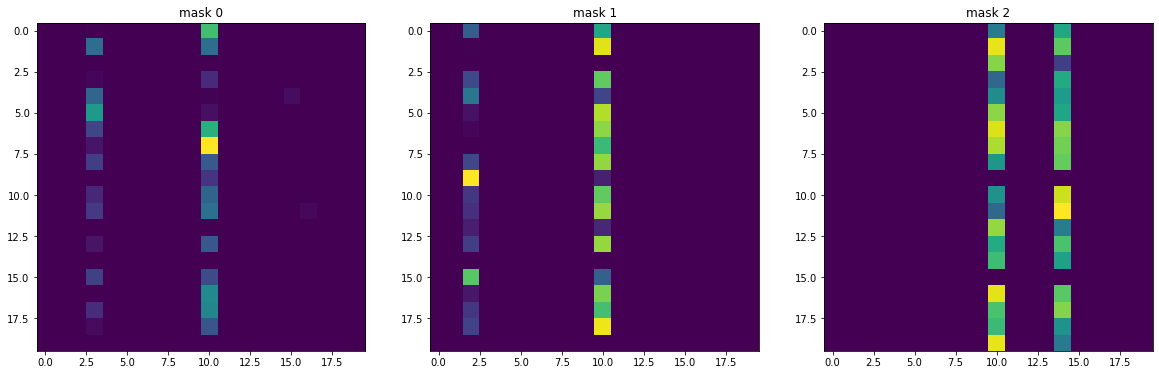

In [31]:
print("TabNet Masks:")
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

around_idx_shift = 10
for i in range(3):
    strong_feature_idx = int(np.median(masks[i].argmax(axis=1)))
    axs[i].imshow(masks[i][:20, max(0, strong_feature_idx - around_idx_shift): strong_feature_idx + around_idx_shift])
    xticks_labels = list(range(max(0, strong_feature_idx - around_idx_shift), strong_feature_idx + around_idx_shift))
    axs[i].set_title(f"mask {i}")

### XGBoost

In [32]:
def init_xgb():
    print("New MultiOutputClassifier(XGBClassifier) initialized.")
    xgb_clf = MultiOutputClassifier(XGBClassifier(tree_method="gpu_hist", use_label_encoder=False, verbosity=0))
    params = {
        "estimator__colsample_bytree": 0.6522,
        "estimator__gamma": 3.6975,
        "estimator__learning_rate": 0.0503,
        "estimator__max_delta_step": 2.0706,
        "estimator__max_depth": 10,
        "estimator__min_child_weight": 31.5800,
        "estimator__n_estimators": 166,
        "estimator__subsample": 0.8639
    }
    xgb_clf = xgb_clf.set_params(**params)
    return xgb_clf

New MultiOutputClassifier(XGBClassifier) initialized.
Training for fold 0:
CPU times: user 5min 8s, sys: 9.43 s, total: 5min 18s
Wall time: 2min 57s


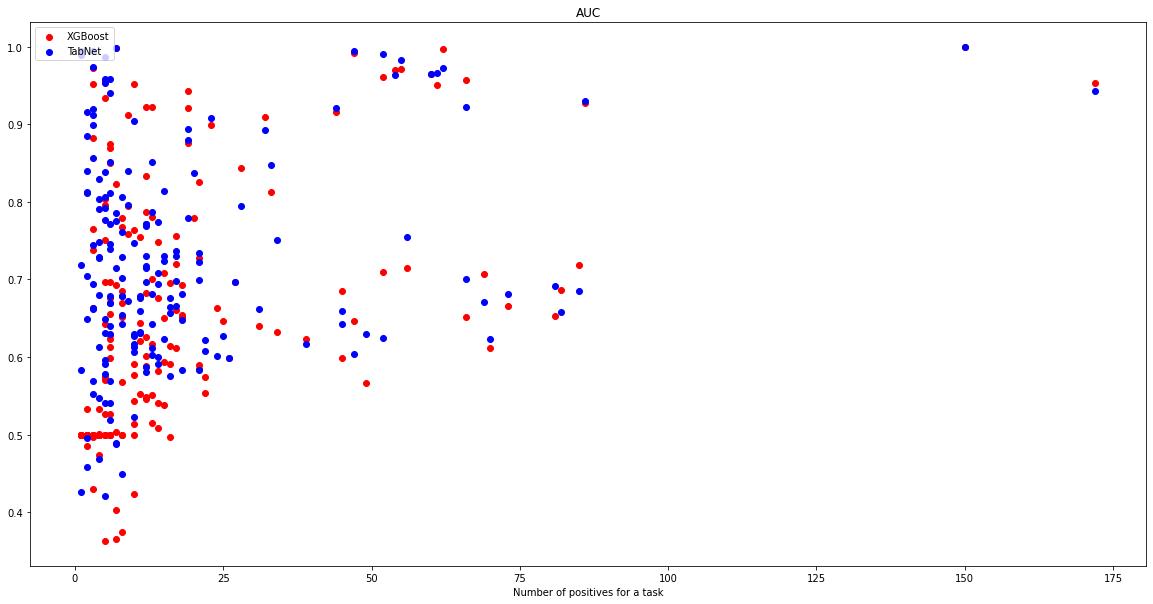

In [33]:
%%time
xgb_clf_0 = fit_and_predict_xgb(init_xgb(), X, y_to_predict, folds, 0, valid_aucs_0)

In [34]:
f"Number of XGB Estimators: {len(xgb_clf_0.estimators_)}"

'Number of XGB Estimators: 177'

New MultiOutputClassifier(XGBClassifier) initialized.
Training for fold 1:
CPU times: user 5min 15s, sys: 9.48 s, total: 5min 25s
Wall time: 2min 59s


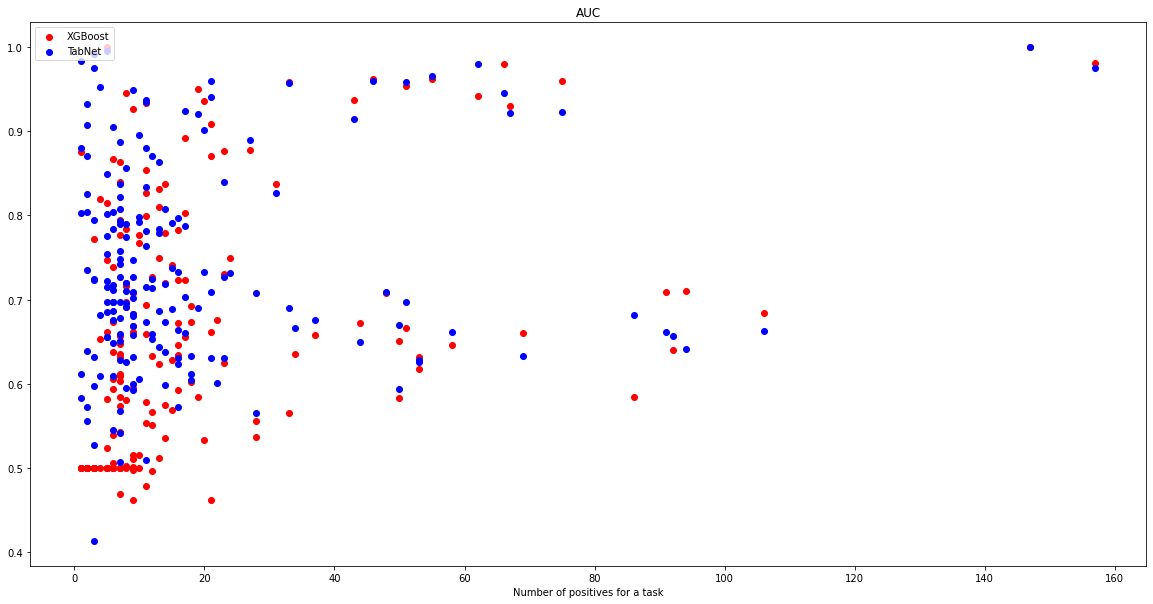

In [35]:
%%time
xgb_clf_1 = fit_and_predict_xgb(init_xgb(), X, y_to_predict, folds, 1, valid_aucs_1)

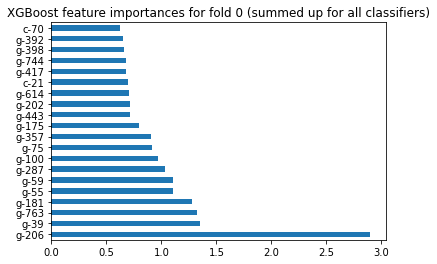

In [36]:
feature_importances_xgb(xgb_clf_0, X, 0)

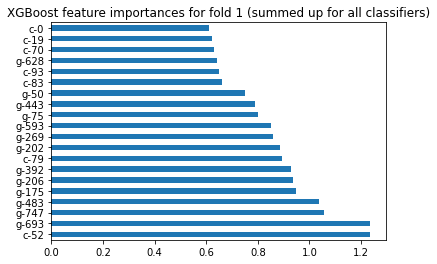

In [37]:
feature_importances_xgb(xgb_clf_1, X, 1)

### TabNet Pretrainer

In [38]:
print("Encode categorical variables in test dataset the same way as they were encoded in train:")
X_test = pd.read_csv("data/test_features.csv")
X_test.drop(columns=["sig_id"], inplace=True)
for cat_id, encoder in zip(cat_ids, encoders):
    feature = X.columns[cat_id]
    print(f"Unique values for {feature}: {X_test.nunique()[feature]}")
    X_test[feature] = X_test[feature].fillna("Encoded_by_Raid")
    X_test[feature] = encoder.transform(X_test[feature].values)
f"X_test shape: {X_test.shape}"

Encode categorical variables in test dataset the same way as they were encoded in train:
Unique values for cp_type: 2
Unique values for cp_time: 3
Unique values for cp_dose: 2


'X_test shape: (3982, 875)'

In [39]:
# Split data on train and valid for Pretrainer
train_valid_split_percentage = 0.8
idx = random.sample(list(range(X_test.shape[0])), X_test.shape[0])
last_train_row_idx = int(train_valid_split_percentage * X_test.shape[0])
X_train_pre, X_valid_pre = X_test.iloc[idx[:last_train_row_idx]].to_numpy(), X_test.iloc[idx[last_train_row_idx:]].to_numpy()

# TabNetPretrainer
unsupervised_model_no_preproc = TabNetPretrainer(
    cat_idxs=cat_ids,
    cat_dims=cat_dimensions,
    cat_emb_dim=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="entmax",
)
unsupervised_model_no_preproc.verbose = 40

# fit the model
unsupervised_model_no_preproc.fit(
    X_train_pre,
    eval_set=[X_valid_pre],
    max_epochs=300 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8
)

# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model_no_preproc.predict(X_valid_pre)
assert(reconstructed_X.shape==embedded_X.shape)

unsupervised_model_no_preproc.save_model("./test_pretrained")
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model("./test_pretrained.zip")

Device used : cuda
epoch 0  | loss: 1.74594 | val_0_unsup_loss: 1.01608 |  0:00:00s
epoch 40 | loss: 0.77336 | val_0_unsup_loss: 0.76229 |  0:00:21s
epoch 80 | loss: 0.73183 | val_0_unsup_loss: 0.72503 |  0:00:43s
epoch 120| loss: 0.71696 | val_0_unsup_loss: 0.70848 |  0:01:04s
epoch 160| loss: 0.69659 | val_0_unsup_loss: 0.68931 |  0:01:25s
epoch 200| loss: 0.69151 | val_0_unsup_loss: 0.66957 |  0:01:47s
epoch 240| loss: 0.66101 | val_0_unsup_loss: 0.65105 |  0:02:08s
epoch 280| loss: 0.65833 | val_0_unsup_loss: 0.64616 |  0:02:30s
Stop training because you reached max_epochs = 300 with best_epoch = 299 and best_val_0_unsup_loss = 0.63536
Best weights from best epoch are automatically used!
Successfully saved model at ./test_pretrained.zip
Device used : cuda
Device used : cuda


New TabNetMultiTaskClassifier initialized.
Device used : cuda
Training for fold 0:
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.5367  | train_auc: 0.51377 | train_logloss: 0.21357 | valid_auc: 0.51424 | valid_logloss: 0.21226 |  0:00:04s
epoch 40 | loss: 0.0182  | train_auc: 0.75786 | train_logloss: 0.01791 | valid_auc: 0.69792 | valid_logloss: 0.01865 |  0:02:47s
epoch 80 | loss: 0.01613 | train_auc: 0.86    | train_logloss: 0.01575 | valid_auc: 0.70468 | valid_logloss: 0.01949 |  0:05:28s

Early stopping occurred at epoch 106 with best_epoch = 56 and best_valid_logloss = 0.0185
Best weights from best epoch are automatically used!


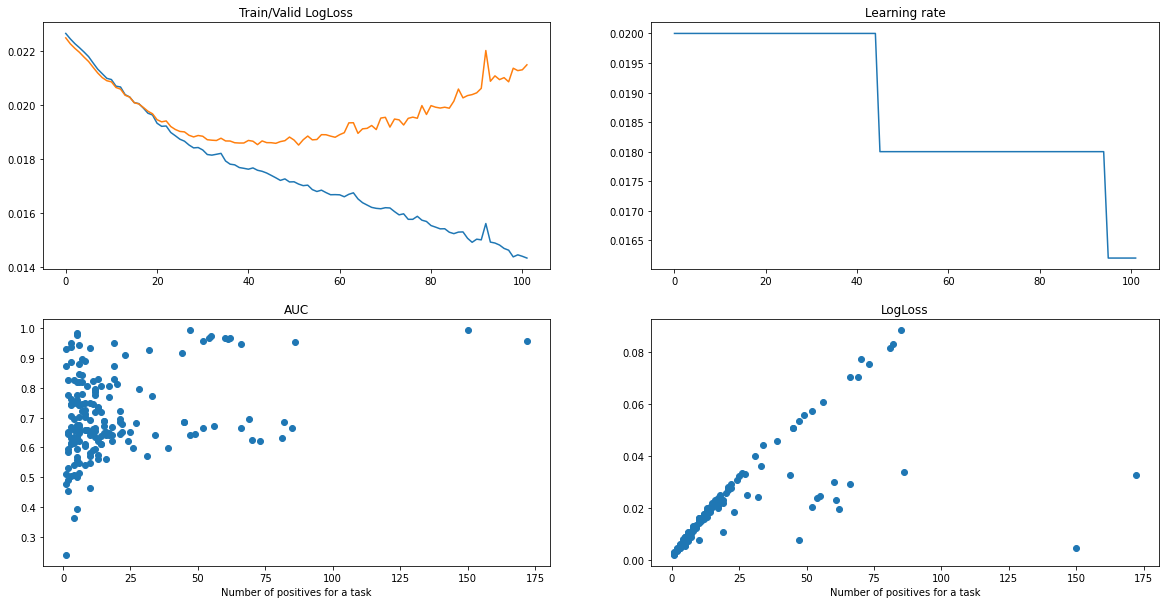

In [40]:
clf_pre_0, valid_aucs_pre_0 = fit_and_predict(init_tabnet(), X, y_to_predict, folds, fold_ix=0, max_epochs=201, verbose=40., unsupervised_model=loaded_pretrain)

In [41]:
auc_diff = [auc_pre0 - auc0 for auc_pre0, auc0 in zip(valid_aucs_pre_0, valid_aucs_0)]
print(f"AUC Difference Median: {np.median(auc_diff)}. Mean: {np.mean(auc_diff)}. Min: {np.min(auc_diff)}. Max: {np.max(auc_diff)}")

AUC Difference Median: -0.004175501437580276. Mean: -0.01920771574146591. Min: -0.4785804283914322. Max: 0.33077015499219026


### Train/test features distribution similarity check (Kolmogorov–Smirnov test)

In [42]:
diff_features = get_diff_distribution_features(X, X_test)

All the features have the same distribution in train and test datasets!


<AxesSubplot:>

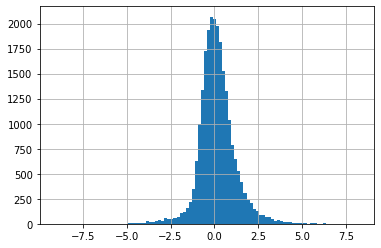

In [43]:
X["g-2"].hist(bins=100)

<AxesSubplot:>

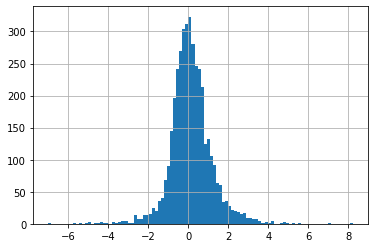

In [44]:
X_test["g-2"].hist(bins=100)

<AxesSubplot:>

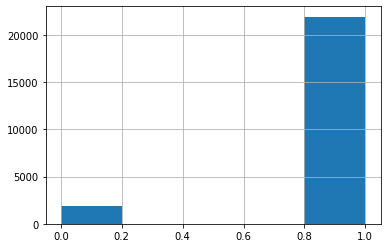

In [45]:
X["cp_type"].hist(bins=5)

<AxesSubplot:>

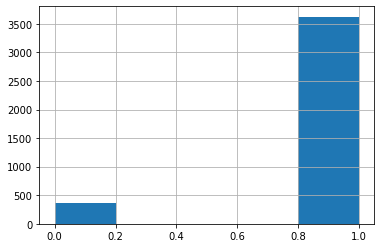

In [46]:
X_test["cp_type"].hist(bins=5)